In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn import metrics
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from xgboost import plot_importance

# **LOADING DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample.csv',encoding="utf-8")
df.Label.value_counts()

Mounted at /content/drive


BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

## **DATA PREPROCESSING**

# **Z - Score Normalization**

In [ ]:
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df = df.fillna(0)

# **Lable-Encoder**


In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.Label.value_counts()

df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

# **K-Mean Clustering**

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

klabel=kmeans.labels_
df_major['klabel']=klabel

df_major['klabel'].value_counts()

cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,133,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,682,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,851,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,976,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,352,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,980,3


In [ ]:
def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

result['Label'].value_counts()

result

result = result.drop(['klabel'],axis=1)
result = result.append(df_minor)

result.to_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km.csv',index=0)

# **Spliting Dataset**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km.csv',encoding = "utf-8")

X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

# **Feature Engineering**

# **Feature Selection By Information Gain**

In [ ]:
importances = mutual_info_classif(X_train, y_train)

f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break     

X_fs = df[fs].values 

X_fs.shape

(4483, 41)

# **Feature Selection by Fast Correlation Based Filter (FCBF)**


In [ ]:
def count_vals(x):
    vals = np.unique(x)
    occ = np.zeros(shape = vals.shape)    
    for i in range(vals.size):
        occ[i] = np.sum(x == vals[i])
    return occ

def entropy(x):
    n = float(x.shape[0])
    ocurrence = count_vals(x)
    px = ocurrence / n
    return -1* np.sum(px*np.log2(px))

def symmetricalUncertain(x,y):
    n = float(y.shape[0])
    vals = np.unique(y)
    # Computing Entropy for the feature x. 
    Hx = entropy(x)
    # Computing Entropy for the feature y.
    Hy = entropy(y)
    #Computing Joint entropy between x and y.
    partial = np.zeros(shape = (vals.shape[0]))
    for i in range(vals.shape[0]):    
       partial[i] = entropy(x[y == vals[i]]) 
    
    partial[np.isnan(partial)==1] = 0      
    py = count_vals(y).astype(dtype = 'float64') / n
    Hxy = np.sum(py[py > 0]*partial) 
    IG = Hx-Hxy
    return 2*IG/(Hx+Hy)

def suGroup(x, n):
    m = x.shape[0]
    x = np.reshape(x, (n,m/n)).T
    m = x.shape[1]
    SU_matrix = np.zeros(shape = (m,m))
    for j in range(m-1):
        x2 = x[:,j+1::]
        y = x[:,j]
        temp = np.apply_along_axis(symmetricalUncertain, 0, x2, y)
        for k in range(temp.shape[0]):
            SU_matrix[j,j+1::] = temp
            SU_matrix[j+1::,j] = temp
    
    return 1/float(m-1)*np.sum(SU_matrix, axis = 1)

def isprime(a):
    return all(a % i for i in xrange(2, a))

def get_i(a):
    if isprime(a):
        a -= 1
    return filter(lambda x: a % x == 0, range(2,a))

class FCBF:
    
    idx_sel = []
    
    
    def __init__(self, th = 0.01):
        
        self.th = th


    def fit(self, x, y):
      
        self.idx_sel = []
       
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        SU_list = SU_vec[SU_vec > self.th]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > self.th].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy()
            self.idx_sel.append(ind)
        
   
        j = 0
        while True:
            
            if j >= x_sorted.shape[1]: break
            y = x_sorted[:,j].copy()
            x_list = x_sorted[:,j+1:].copy()
            if x_list.shape[1] == 0: break
                
                
            SU_list_2 = SU_list[j+1:]
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0:
                x_sorted = np.delete(x_sorted, to_remove, axis = 1)
                SU_list = np.delete(SU_list, to_remove, axis = 0)
                to_remove.sort()
                for r in reversed(to_remove): 
                    self.idx_sel.remove(self.idx_sel[r])
            j = j + 1        
            
    def fit_transform(self, x, y):
        
        self.fit(x, y)
        return x[:,self.idx_sel]
         
    def transform(self, x):
       
        return x[:, self.idx_sel]  



class FCBFK(FCBF):
    
    idx_sel = []
    
    
    def __init__(self, k = 10):
       
        self.k = k


    def fit(self, x, y):
       
        self.idx_sel = []
        
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        SU_list = SU_vec[SU_vec > 0]
        SU_list[::-1].sort()
        
        m = x[:,SU_vec > 0].shape
        x_sorted = np.zeros(shape = m)
        
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = 0
            x_sorted[:,i] = x[:,ind].copy() 
            self.idx_sel.append(ind)
        
        j = 0
        while True:
            y = x_sorted[:,j].copy()
            SU_list_2 = SU_list[j+1:]    
            x_list = x_sorted[:,j+1:].copy()
            
          
            if x_list.shape[1] == 0: break
                
                
            SU_x = np.apply_along_axis(symmetricalUncertain, 0, 
                                       x_list, y)
            
            comp_SU = SU_x >= SU_list_2
            to_remove = np.where(comp_SU)[0] + j + 1 
            if to_remove.size > 0 and x.shape[1] > self.k:
    
                for i in reversed(to_remove):
                    
                    x_sorted = np.delete(x_sorted, i, axis = 1)
                    SU_list = np.delete(SU_list, i, axis = 0)                
                    self.idx_sel.remove(self.idx_sel[i])
                    if x_sorted.shape[1] == self.k: break  
                    
            if x_list.shape[1] == 1 or x_sorted.shape[1] == self.k: 
                break    
            j = j + 1
            
        if len(self.idx_sel) > self.k:
            self.idx_sel = self.idx_sel[:self.k]
                   
            
class FCBFiP(FCBF):
    
    idx_sel = []


    def __init__(self, k = 10, npieces = 2):
        self.k = k
        self.npieces = npieces

    def fit(self, x, y):
        m = x.shape
        nfeaturesPieces = int(m[1] / float(self.npieces))        
        SU_vec = np.apply_along_axis(symmetricalUncertain, 0, x, y)
        
        x_sorted = np.zeros(shape = m, dtype = 'float64')        
        idx_sorted = np.zeros(shape = m[1], dtype = 'int64')
        for i in range(m[1]):
            ind = np.argmax(SU_vec)
            SU_vec[ind] = -1
            idx_sorted[i]= ind 
            x_sorted[:,i] = x[:,ind].copy() 

        if isprime(m[1]): 
            x_sorted = np.delete(x_sorted, m[1]-1, axis = 1 )
            ind_prime = idx_sorted[m[1]-1]
            idx_sorted = np.delete(idx_sorted, m[1]-1)
            #m = x_sorted.shape
        
        
        x_2d = np.reshape(x_sorted.T, (self.npieces, nfeaturesPieces*m[0])).T
    
        SU_x =  np.apply_along_axis(suGroup, 0, x_2d, nfeaturesPieces)
        SU_x = np.reshape(SU_x.T, (self.npieces*nfeaturesPieces,))
        idx_sorted2 = np.zeros(shape = idx_sorted.shape, dtype = 'int64')
        SU_x[np.isnan(SU_x)] = 1        
        
        for i in range(idx_sorted.shape[0]):
            ind =  np.argmin(SU_x)
            idx_sorted2[i] = idx_sorted[ind]
            SU_x[ind] = 10    
       
        self.scores = np.zeros(shape = m[1], dtype = 'int64') 
           
        for i in range(m[1]):
            if i in idx_sorted:
                self.scores[i] = np.argwhere(i == idx_sorted) + np.argwhere(i == idx_sorted2)
        if isprime(m[1]): 
            self.scores[ind_prime] = 2*m[1]
        self.set_k(self.k)


    def set_k(self, k):
        self.k = k 
        scores_temp = -1*self.scores
        
        self.idx_sel = np.zeros(shape = self.k, dtype = 'int64')
        for i in range(self.k):
            ind =  np.argmax(scores_temp)
            scores_temp[ind] = -100000000
            self.idx_sel[i] = ind

In [ ]:
fcbf = FCBFK(k = 20)
fcbf.fit(X_fs, y)

X_fss = fcbf.fit_transform(X_fs,y)

X_fss.shape

(4483, 20)

# **Spliting Dataset After Feature Selection**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

X_train.shape

pd.Series(y_train).value_counts()

6    1744
1    1573
0      94
3      84
5      45
4      29
2      17
dtype: int64

# **SMOTE To Solve Class-Imbalance**

In [ ]:
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

X_train, y_train = smote.fit_resample(X_train, y_train)

pd.Series(y_train).value_counts()

6    1744
1    1573
4    1000
2    1000
0      94
3      84
5      45
dtype: int64

# **Machine Learning Model Training** 

# **Desicion Tree**

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)


Accuracy of DT: 0.9966555183946488
Precision of DT: 0.9968480968505842
Recall of DT: 0.9966555183946488
F1-score of DT: 0.996594798191746
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.95      1.00      0.98        21
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.98      0.98      0.98       897
weighted avg       1.00      1.00      1.00       897



# **Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)

Accuracy of RF: 0.9955406911928651
Precision of RF: 0.996086843912931
Recall of RF: 0.9955406911928651
F1-score of RF: 0.9955815249799072
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       0.95      1.00      0.98        21
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.96      0.98      0.97       897
weighted avg       1.00      1.00      1.00       897



# **XG-Boost**

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)

Accuracy of XGBoost: 0.9955406911928651
Precision of XGBoost: 0.995581230363839
Recall of XGBoost: 0.9955406911928651
F1-score of XGBoost: 0.9954386794620025
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       1.00      1.00      1.00       393
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        12
           6       0.99      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       1.00      0.98      0.99       897
weighted avg       1.00      1.00      1.00       897



# **Extra Tree**

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)

Accuracy of ET: 0.9955406911928651
Precision of ET: 0.9958545392855411
Recall of ET: 0.9955406911928651
F1-score of ET: 0.9956034972715683
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       1.00      1.00      1.00       393
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00        21
           4       0.88      1.00      0.93         7
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           1.00       897
   macro avg       0.95      0.99      0.96       897
weighted avg       1.00      1.00      1.00       897



#  **Anomaly-based IDS** 

# Generate The Port-Scan Datasets For Unknown Attack Detection

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km.csv')


df.Label.value_counts()

df1 = df[df['Label'] != 5]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km_without_portscan.csv',index=0)

df2 = df[df['Label'] == 5]
df2['Label'][df2['Label'] == 5] = 1
df2.to_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km.csv_portscan.csv',index=0)

# Read The Generated Datasets For Unknown Attack Detection

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km_without_portscan.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample_km.csv_portscan.csv')

features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

df1.Label.value_counts()7

df2.Label.value_counts()

1    57
Name: Label, dtype: int64

In [ ]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1255/18225, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

df2.Label.value_counts()

df = df1.append(df2)

X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

1    4365
0     126
dtype: int64

# **Feature Engineering** 

# Feature Selection by Information Gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break 

X_fs = df[fs].values

X_fs

array([[-1.23887277, -0.06764699, -0.06764699, ...,  0.32869268,
        -0.13888988, -0.02915145],
       [-1.25912665, -0.06672318, -0.06672318, ..., -0.74441831,
        -0.13888735, -0.04137752],
       [-0.61344546, -0.06762059, -0.06762059, ..., -0.67929003,
        -0.05901513, -0.04119639],
       ...,
       [-1.25912665, -0.06674958, -0.06674958, ..., -0.74441968,
        -0.13885956, -0.04133224],
       [-1.25912665, -0.06685516, -0.06685516, ..., -0.74440704,
        -0.13885893, -0.03933984],
       [-1.17834754, -0.06791093, -0.06791093, ..., -0.74442793,
        -0.13888988, -0.03929456]])

# Feature Selection by Fast Correlation Based Filter



In [ ]:
fcbf = FCBFK(k = 20)
X_fss = fcbf.fit_transform(X_fs,y)
X_fss.shape
X_fss

array([[ 0.78298135,  0.78189607, -0.22674493, ..., -0.22442521,
        -0.23482476, -0.08569367],
       [ 8.14258422,  8.13968248,  7.21894807, ...,  0.13358435,
         0.08079543, -0.09072586],
       [-0.29403371, -0.29485316, -0.22674493, ...,  6.8389573 ,
         5.71106898, -0.08820977],
       ...,
       [ 7.96308171,  7.96022428,  6.91504224, ...,  0.11897171,
         0.06948656, -0.09827415],
       [ 7.24507167,  7.24239146,  8.43457142, ...,  0.19203489,
         0.09827277, -0.09072586],
       [ 0.06497131,  0.06406325, -0.22674493, ..., -0.22442521,
        -0.25538634, -0.09575806]])

# Kernel Principal Component Analysis

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

# Train-Test Split After Feature Selection

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

# Solve Class-Imbalance by SMOTE

In [ ]:
pd.Series(y_train).value_counts()

from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_resample(X_train, y_train)

pd.Series(y_train).value_counts()

pd.Series(y_test).value_counts()

1    57
0     8
dtype: int64

# Apply The Cluster Labeling K-Means Method

In [ ]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.88      1.00      0.93        57

    accuracy                           0.88        65
   macro avg       0.44      0.50      0.47        65
weighted avg       0.77      0.88      0.82        65

0.8769230769230769
[[ 0  8]
 [ 0 57]]


# CNN For IDS

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cyber_Security/CICIDS2019_sample.csv',encoding="utf-8")
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df = df.fillna(0)


In [ ]:
x = df

labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

y = pd.DataFrame(df['Label'],columns=['Label'])
del x['Label']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain,ytest = train_test_split(x,y,test_size = 0.20)

In [ ]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(77,1)))
model.add(MaxPooling1D())
model.add(Dense(16, activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',optimizer = "adam",metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 76, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 38, 64)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 38, 16)            1040      
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 4263      
                                                                 
Total params: 5,495
Trainable params: 5,495
Non-trainable params: 0
______________________________________________________

In [ ]:
history = model.fit(xtrain, ytrain, epochs=10 )

Epoch 1/10
1417/1417 [==============================] - 12s 8ms/step - loss: 0.3662 - accuracy: 0.8762
Epoch 2/10
1417/1417 [==============================] - 10s 7ms/step - loss: 0.2196 - accuracy: 0.9199
Epoch 3/10
1417/1417 [==============================] - 10s 7ms/step - loss: 0.2017 - accuracy: 0.9261
Epoch 4/10
1417/1417 [==============================] - 11s 8ms/step - loss: 0.1877 - accuracy: 0.9309
Epoch 5/10
1417/1417 [==============================] - 11s 8ms/step - loss: 0.1791 - accuracy: 0.9332
Epoch 6/10
1417/1417 [==============================] - 9s 6ms/step - loss: 0.1761 - accuracy: 0.9343
Epoch 7/10
1417/1417 [==============================] - 12s 8ms/step - loss: 0.1646 - accuracy: 0.9378
Epoch 8/10
1417/1417 [==============================] - 11s 8ms/step - loss: 0.1585 - accuracy: 0.9401
Epoch 9/10
1417/1417 [==============================] - 10s 7ms/step - loss: 0.1551 - accuracy: 0.9416
Epoch 10/10
1417/1417 [==============================] - 10s 7ms/step - lo

In [ ]:
accuracy = model.evaluate(xtest,ytest)

355/355 [==============================] - 1s 3ms/step - loss: 0.1432 - accuracy: 0.9476


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[str(metric)], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric])


(0.0, 0.37702846750617025)

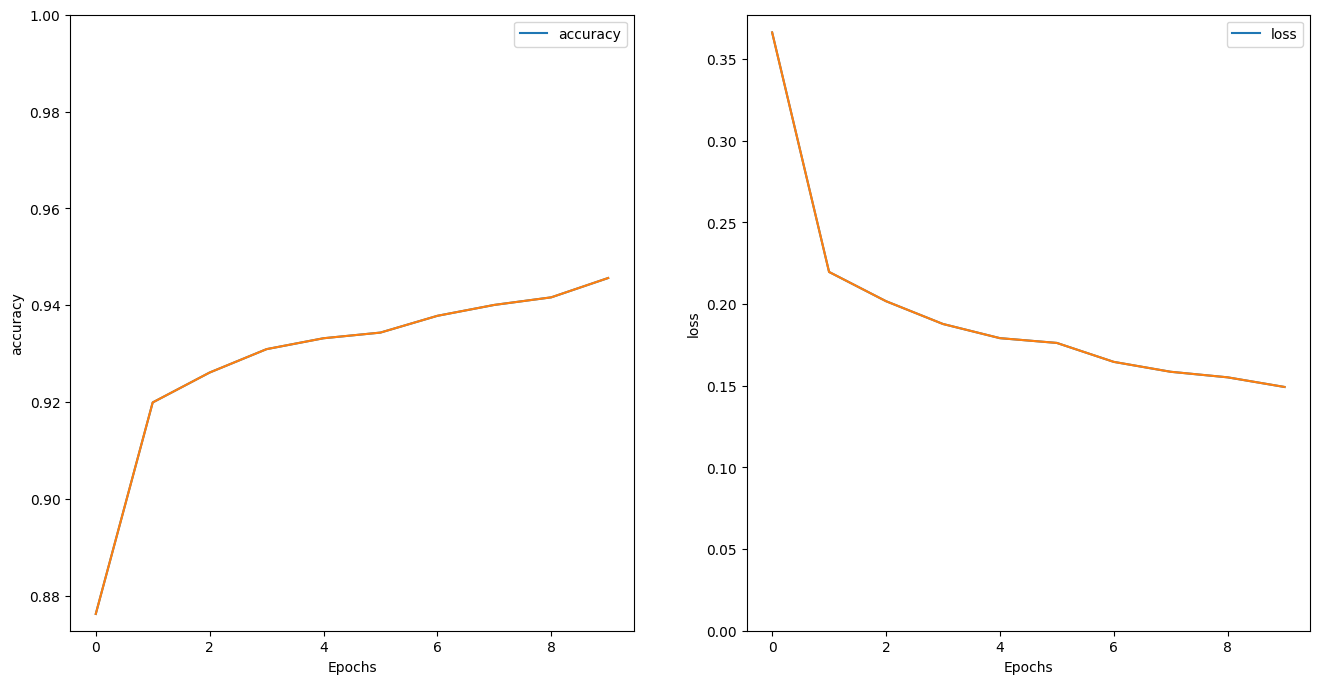

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)